In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm



In [2]:
df_boot = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [3]:
df_boot.drop('Unnamed: 0',axis=1, inplace=True)

In [4]:
df_boot = df_boot.rename(columns={'experimentVariant':'group'})

In [5]:
df_boot.head()

,value,group
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [6]:
df_boot.group.unique()

array(['Control', 'Treatment'], dtype=object)

In [7]:
df_boot.dtypes


value    float64
group     object
dtype: object

In [8]:
df_boot_control = df_boot.query('group == "Control"').value
df_boot_test = df_boot.query('group == "Treatment"').value

In [9]:
df_boot_control.shape

(500,)

In [10]:
df_boot_control = pd.DataFrame(df_boot_control)
df_boot_test = pd.DataFrame(df_boot_test)

In [11]:
df_boot_control

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808
...,...
495,10.973929
496,10.261074
497,8.780090
498,11.169078


In [12]:
#Критерий Манна-Уитни
mannwhitneyu(df_boot_control.value, df_boot_test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [13]:
#Считаем бутстрап с медианами
def get_bootstrap(
    control_values,
    test_values,
    boot_it=3000,
    statistic=np.median,
    bootstrap_conf_level = 0.95    
):
    boot_len = max([len(control_values), len(test_values)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_control = control_values.sample(
            boot_len,
            replace=True
        ).values
        
        samples_test = test_values.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_test-samples_control)) 
    
    df_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    ci = df_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    
    p_value = min(p_1, p_2) * 2
    
    
    plt.hist(df_boot_data[0], bins = 50)
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.vlines(statistic(boot_data), ymin=0, ymax=180, linestyle='-', colors='k')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/3000 [00:00<?, ?it/s]

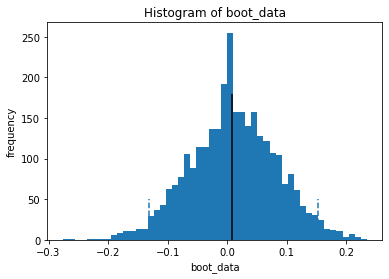

0.8871430793864832

In [14]:
#Для медианы
get_bootstrap(df_boot_control.value, df_boot_test.value)['p_value']

  0%|          | 0/3000 [00:00<?, ?it/s]

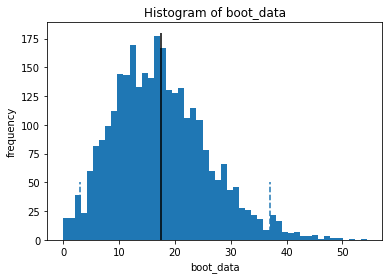

0.03925592342014697

In [15]:
#Для среднего
get_bootstrap(df_boot_control.value, df_boot_test.value, statistic=np.mean)['p_value']

Таким образом, бутстрап по медиане и критерий Манна-Уитни показали, что статистически значимого различия между тестовой и контрольной группой нет. В то время как бутстрап по среднему дал статистически значимое различие.

Подобная ситуация говорит о том, что в данных присутствует либо несимметричное распределение, либо выбросы. Проверим на наличие выбросов.

In [20]:
df_boot_control.std()[0]

0.9793773878665699

In [19]:
df_boot_test.std()[0]

186.55701125985144

In [21]:
df_boot_control.max()

value    13.130346
dtype: float64

In [22]:
df_boot_control.min()

value    6.436541
dtype: float64

In [23]:
df_boot_test.max()

value    3000.0
dtype: float64

In [24]:
df_boot_test.min()

value    6.436541
dtype: float64

In [27]:
df_boot_test.sort_values(by='value', ascending=False)[:20]

,value
999,3000.000000
998,2000.000000
997,1500.000000
996,1200.000000
995,1000.000000
671,13.130346
695,12.817541
794,12.728285
863,12.663784
719,12.598569


Судя по всему, в тестовой группе есть некоторые выбросы, число которых равно 5. Попробуем посчитать результат без них.

In [30]:
df_boot_test_without_outliers = df_boot_test.sort_values(by='value', ascending=False)[5:]

  0%|          | 0/3000 [00:00<?, ?it/s]

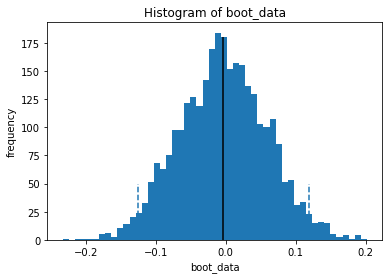

0.9521792660615482

In [31]:
get_bootstrap(df_boot_control.value, df_boot_test_without_outliers.value, statistic=np.mean)['p_value']

Таким образом, без учета выбросов бутстрап по среднему также показывает отсутствие статистически значимого различия. Это говорит о том, что на данный момент нет причин выкатывать тестовую версию на всех